# Idealised Galaxy Disk Simulations

Here we will use the [DICE](https://bitbucket.org/vperret/dice/src/master/) initial conditions generator to create galaxy disk initial conditions (ICs).

Begin by going to the [DICE](https://bitbucket.org/vperret/dice/src/master/) website and follow the [instructions](https://bitbucket.org/vperret/dice/wiki/Compile%20&%20Install) there to download and install the code. Depending on your C compiler version, you may need the following 'extra' parameters with cmake when installing:

```bash
cmake .. -DCMAKE_C_FLAGS="-fcommon"
```

After installation (cmake, make, and make install), you should obtain a `dice` directory which contains the executable here `dice/build/bin/dice`. 

You can then run DICE with the dwarf galaxy configuration files found in `ramses-tutorials/Idealised-Disc-Galaxy/ICs/dwarf_galaxy/`. This generates ICs that RAMSES can read to run a simulation of an isolated galaxy. The RAMSES namelist needs to know where the ICs are stored, so we will generate the ICs into that same sub-subfolder with (it should take ~2 min.): 

```bash
cd ICs/dwarf_galaxy
/path/to/dice/build/bin/dice dwarf_galaxy.config
```

You should now have 6 additional files in that folder: `dwarf_galaxy.params.rzN` (N=1-5) and `dwarf_galaxy.g2`. We will now run and analyze a RAMSES simulation with this fiducial dwarf galaxy. Later on, feel free to play with the DICE parameter files (.config and .params) to generate your own galaxy ICs with different properties (e.g. halo and stellar mass, gas to stellar mass fraction, disc thickness etc.).

## Running RAMSES with DICE ICs

For running with the DICE ICs, RAMSES needs to be compiled with the DICE patch. For this, go to the directory in which you cloned RAMSES and type: 

```bash
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ EXEC=ramses-dice
```

After the code has compiled, We will run a $~10^{10} \ M_{\odot}$ halo with $~50$ pc resolution, star formation and supernovae feedback (but no radiation), so this simulation takes some time to get to the end goal of $250 \ {\rm Myr}$ of galaxy disk evolution. Still, the first outputs will be written shortly, and you will be able to continue the tutorial while the simulation is running. To start the simulation, go to the sub-directory `dwarf_galaxy_run/` and run RAMSES as follows:
```bash
cd dwarf_galaxy_run
mpirun -np 8 ../path/to/ramses/bin/ramses-dice3d setup.nml > run.log &
```
In this example we are using 8 cores, you might need to use less if you are running this locally, and you should use more if you have access to more. 
The simulation will eventually return 50 `~unsure~` outputs and two movie files. Also, the command is run in the background (with `&`). Should you want to stop the simulation, type `fg` in the terminal, which will bring back the run to the foreground, and use `ctrl-C`. 

You can check the evolution of the simulation through the log file as the run progresses, for example with (type `ctrl-C` to stop):

```bash
tail -f run.log
```

You can then play with increasing the resolution, using more sophisticated models for star formation or feedback in your namelist file (`setup.nml`). See the [RAMSES documentation](https://ramses-organisation.readthedocs.io/en/latest/) for descriptions of the available parameters. You can also generate different galaxy disk ICs with DICE. Start from the configuration files coming with this tutorial and refer to the DICE documentation for an overview of the parameters and what they do. Now that you have a few outputs, we can execute the notebook cells below to do some visualisation.

## Visualizing the outputs with [yt](https://yt-project.org/)

In [1]:
# Import the relevant modules for reading RAMSES outputs and visualising them
import yt
import numpy as np
from matplotlib import pyplot as plt
yt.set_log_level(0)

In [2]:
# Load RAMSES snapshot with Yt
RHD=False # Set to true if running RAMSES-RT -- this is for later.
snap=9 # Snapshot number to look at -- You need to change this as you get more outputs!!!
snapstr = "%05d" % snap
path='./dwarf_galaxy_run/'
if RHD: path='./dwarf_galaxy_rhd_run/'
ds = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')

In [3]:
# Show the available variables
#sorted(ds.field_info)

The total gas mass is  139657718.12392405 Msun



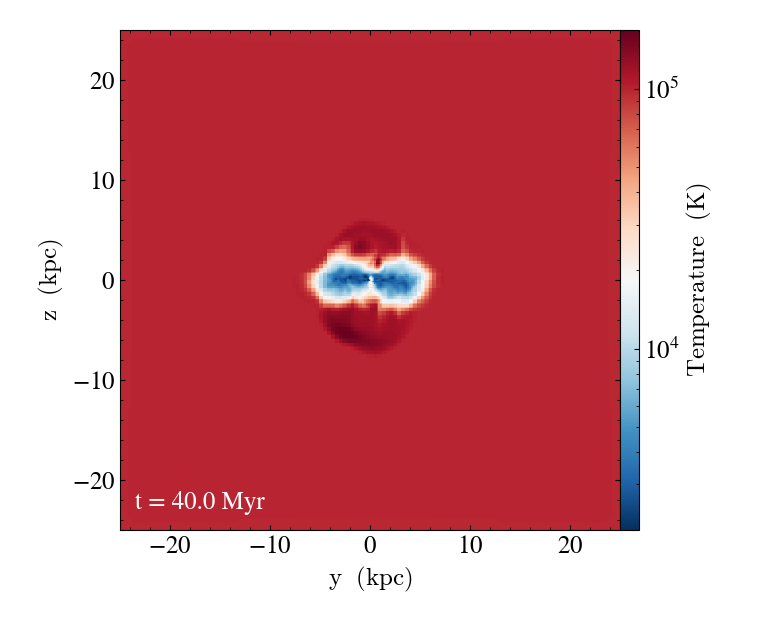


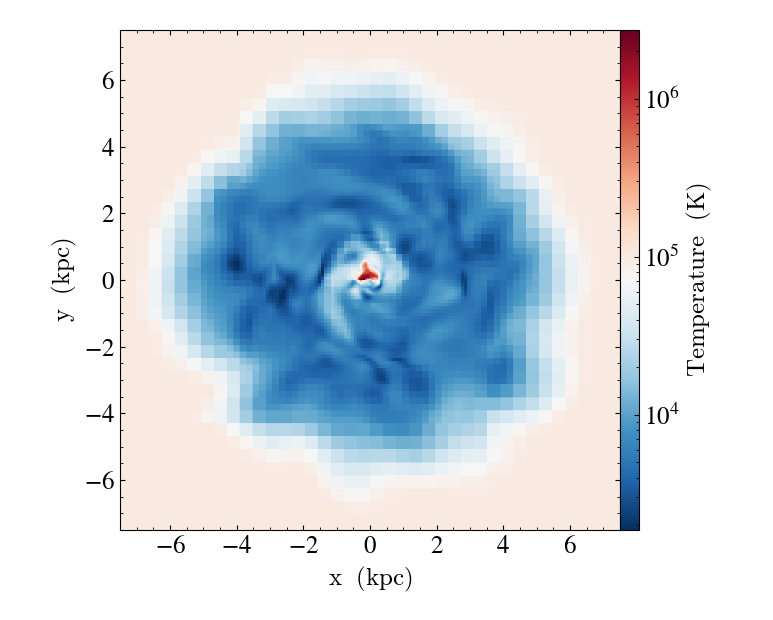


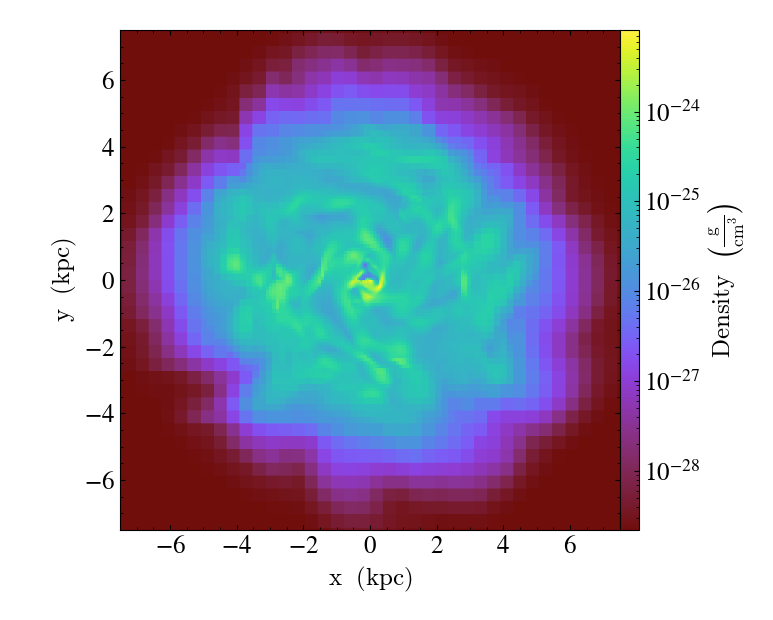


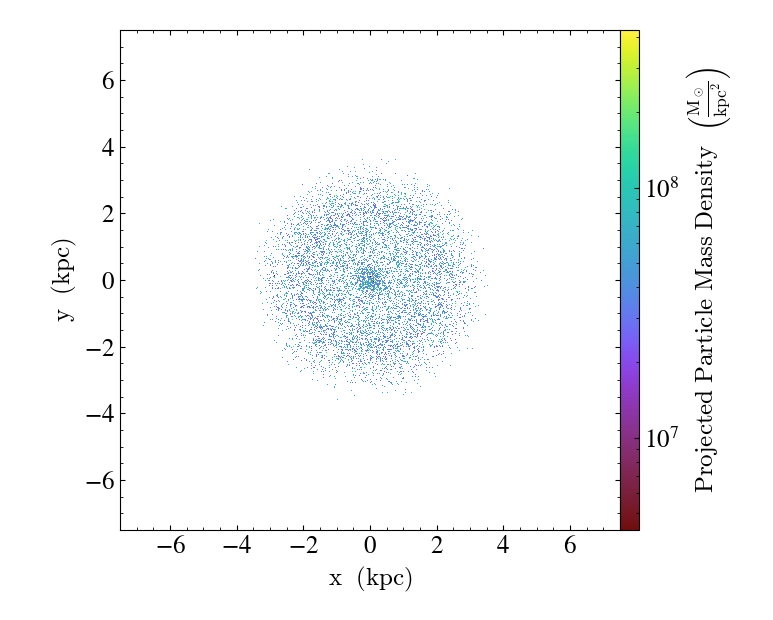

In [4]:
# Show projection maps
ad=ds.all_data()
m_tot = np.sum(ad['density']*ad['dx']**3)
print("The total gas mass is ",m_tot.in_units('Msun'))
time_Myr = ds.current_time.in_units('Myr')

# projection of the full box in temperature, face-on
p = yt.ProjectionPlot(ds, 'x', 'temperature',weight_field='density')
p.annotate_timestamp()
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

# zoomed-in projection of temperature, density, and stars
p = yt.ProjectionPlot(ds, 'z', 'temperature',weight_field='density',width=(15,'kpc'))
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

p = yt.ProjectionPlot(ds,'z', 'density',width=(15,'kpc'), method="max")
p.set_unit('density', 'g/cm**3')
p.set_figure_size(5)
p.show()

p = yt.ParticleProjectionPlot(ds, 2, [("star", "particle_mass")], width=(15,'kpc'), density=True)
p.set_unit(("star", "particle_mass"), "Msun/kpc**2")
p.set_figure_size(5)
p.show()

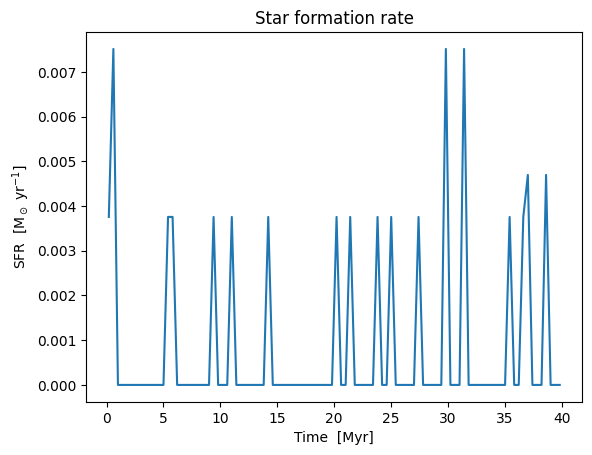

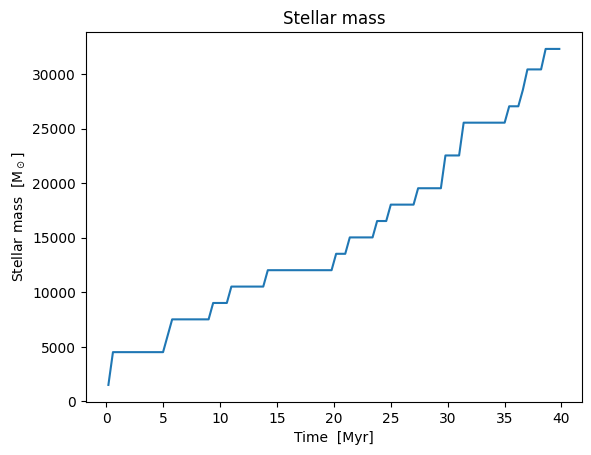

In [5]:
# Plot star formation history.
# You need to use an output with star particles for this to work -> change the value of snap!
plt.ion() # So as to show plots
ad = ds.all_data()
masses = ad['star', 'particle_mass'].in_units('Msun')
formation_time = ad['star', 'particle_birth_time'].in_units('yr')
time_yr = ds.current_time.in_units('yr')
time_range = [-100, time_yr.v] # years
n_bins = 100
hist, bins = np.histogram(formation_time, bins=n_bins, range=time_range,)
inds = np.digitize(formation_time, bins=bins)
time = (bins[:-1] + bins[1:])/2
sfr = np.array([masses[inds == j+1].sum()/(bins[j+1]-bins[j])
                for j in range(len(time))])
mass = np.array([masses[inds == j+1].sum()
                for j in range(len(time))])
mass= np.cumsum(mass)
# SFR plot
plt.plot(time/1e6, sfr)
plt.title('Star formation rate')
plt.xlabel('Time  [Myr]')
plt.ylabel(r'SFR  [M$_\odot$ yr$^{-1}$]')
plt.show()

# Plot of stellar mass formed
fig=plt.figure()
plt.plot(time/1e6, mass)
plt.title('Stellar mass')
plt.xlabel('Time  [Myr]')
plt.ylabel(r'Stellar mass  [M$_\odot$]')
plt.show()

## Making movies

The RAMSES simulation namelist contains MOVIE_PARAMS, which tell the code to generate binary files with short time intervals showing  face-on and edge-on projections of gas density, temperature, and stars.

The first cell below reads those binary files and creates .png images out of them, each with the density, temperature, and stars superimposed.

The second cell then calls ffmpeg to squeeze all those pngs into one .mp4 movie file. For that second cell to work, you need to have ffmpeg installed.

In [ ]:
# Read binary movie frames and make .png images
import os
import glob
import numpy as np
from scipy.io import FortranFile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mov_proj = 1 # Movie projection (1=face-on, 2=edge-on)     ####################CHANGE THIS FOR DIFFERENT PROJECTION

plt.ioff() # So as not to show plots
#plt.ion() # So as to show plots
fig = plt.figure(frameon=False)
nx = 500
ny = 500
nypic=ny  #int(ny*0.6)
plt.subplots_adjust(left=0., bottom=0.,
                    right=1.+1.0/nx, top=1.+1.0/nypic,
                    wspace=0., hspace=0.)
fig.set_size_inches(nx/100.*.7,nypic/100.*.7)
quants = {
    "temp": {
        "name": "temp",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "dens": {
        "name": "dens",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "stars": {
        "name": "stars",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }
}

if RHD:
    quants.update({
    "Fp1": {
        "name": "Fp1",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }}
    )

d_cmap=matplotlib.cm.viridis

cmap = matplotlib.cm.bone
stars_cmap = cmap(np.arange(cmap.N))
stars_cmap[:,-1] = np.linspace(0, 1, cmap.N)
stars_cmap = ListedColormap(stars_cmap)

cmap = matplotlib.cm.RdBu_r
temp_cmap = cmap(np.arange(cmap.N))
temp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
temp_cmap = ListedColormap(temp_cmap)

cmap = matplotlib.cm.cividis
fp_cmap = cmap(np.arange(cmap.N))
fp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
fp_cmap = ListedColormap(fp_cmap)

movie_path = '%s/movie%d/'%(path,mov_proj)
png_dir = '%s/pngs'%(path)
try:
    os.mkdir(png_dir) # Create directory to store movie frames in png files
except FileExistsError:
    do_nothing=True
all_ok = True

# Figure out the number of frames for the movie
searchstring = '%s/info_'%(movie_path)
frames = glob.glob(searchstring+'*') # Frame strings
i_frames = [ int(str[len(searchstring):len(searchstring)+4]) for str in frames ]
i_frames = sorted(i_frames)         # Sort them
imin = i_frames[0]
imax = i_frames[len(i_frames)-1]

# Loop over the movie frames and generate .png images
for i in range(imin,imax+1):
    # Read the info file:
    info = open(f"{movie_path}info_{str(i).zfill(5)}.txt").readlines()
    time_sec=0.0
    time_sec = float(info[8].split("=")[-1].strip())
    unit_l =   float(info[15].split("=")[-1].strip())
    unit_d =   float(info[16].split("=")[-1].strip())
    unit_t =   float(info[17].split("=")[-1].strip())
    time_myr = time_sec*unit_t/3.156e13
    
    # Load in the data
    for q in quants:
        fname = f"{quants[q]['name']}_{str(i).zfill(5)}.map"
        ffile = FortranFile(f"{movie_path}{fname}")
        [time, fdw, fdh, fdd] = ffile.read_reals('d')
        [frame_nx, frame_ny] = ffile.read_ints()
        data = np.array(ffile.read_reals('f4'), dtype=np.float64)
        try: 
            quants[q]["data"] = data.reshape(frame_nx,frame_ny)
            quants[q]["min"] = quants[q]["data"][quants[q]["data"] > 0].min()
            quants[q]["max"] = quants[q]["data"][quants[q]["data"] > 0].max()
            quants[q]["data"][quants[q]["data"] < quants[q]["min"]] = 1e-5 * quants[q]["min"]
        except ValueError:
            all_ok = False
        f, axs = plt.subplots(1,1,figsize=(7.5,7.5),sharex=True,sharey=True)
    plt.subplots_adjust(left=0, right=1.0, top=1.0, bottom=0)
    axs.imshow(np.log10(quants["dens"]["data"]),vmin=-6,vmax=2,cmap=d_cmap,aspect='auto',interpolation='none')
    if RHD:
        axs.imshow(np.log10(quants["Fp1"]["data"]),vmin=-6,vmax=2,cmap=fp_cmap,aspect='auto',alpha=0.5)
    else:
        axs.imshow(np.log10(quants["temp"]["data"]),vmin=4.5,vmax=6.5,cmap=temp_cmap)
        axs.imshow(np.log10(quants["stars"]["data"]),vmin=-5,vmax=-2,cmap=stars_cmap,alpha=0.5)
    plt.axis("off")
    # Text showing simulation time
    axs.text(0.97, 0.03,'%.2f Myr'%(time_myr), fontsize=15,transform=axs.transAxes
             , verticalalignment='bottom', horizontalalignment='right', color='white')
    # Bar showing length scale
    frame_width_kpc = fdw*unit_l/3.08e21
    rect = mpatches.Rectangle((0.055,0.03),10./frame_width_kpc,0.002,color='white',transform=axs.transAxes)
    axs.add_patch(rect)
    axs.text(0.055, 0.01+15./frame_ny, ('%d kpc'%(10)),
            verticalalignment='bottom', horizontalalignment='left',
            transform=axs.transAxes, color='white', fontsize=15. )
   
    # Store frame in png file
    filename = '%s/frame_%d_%05d.png'%(png_dir,mov_proj,i)
    print(filename)
    f.savefig(filename, dpi=100)

In [ ]:
# Run ffmpeg to make a .mp4 out of the .png frames
import subprocess
movie_filename = '%smovie%d.mp4'%(path,mov_proj)
frames = '%spngs/frame_%d_%%*.png'%(path,mov_proj)
fps=50.
speed=60.
quality=23
print("Calling ffmpeg! Output: {mov}".format(mov=movie_filename))
print("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=speed/fps,
                           quality=quality, output=movie_filename))
subprocess.call("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=60./fps,
                           quality=quality, output=movie_filename), shell=True)
print('####################################################################')
print('-----------Your new movie is here: ', movie_filename)
print('####################################################################')

## RHD run
Now you can do the same run with radiation-hydrodynamics (RHD) and include ionising radiation from stars. You first need to compile RAMSES with the RHD options of three radiation groups and 3 ionisation fractions (xHII, xHeII, and xHeIII): 
```bash
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ RT=1 NGROUPS=3 NIONS=3 EXEC=ramses-dice-rhd
```

After the code has compiled, you can go to the sub-directory named `dwarf_galaxy_rhd_run/` and run RAMSES as follows:
```bash
cd dwarf_galaxy_rhd_run
mpirun -np 8 ../ramses/bin/ramses-dice-rhd3d setup.nml > run.log &
```

You can then use the visualization routines above to look at the outputs from the RHD run. Just remember to change ```path``` when loading the RAMSES outputs with yt. The cell below is for making a movie including the ionising radiation flux.

## AGN feedback

The prepared namelist file includes a SINK_PARAMS namelist for including the a black hole of mass $10 \times 10^7 \ M_{\odot}$ in the
initial conditions, as well as thermal AGN feedback. You can activate this by setting sink=.true. and clumpfind=.true. in your
namelist.

...and now you are free to experiment with ramses parameters or generating different galaxies with DICE.

## Understanding the namelist
In the previous sections, we tested different simulation types without delving into the details of their parameters, i.e. the namelist `setup.nml`. In this section we explain in more details how the namelist works.   

The namelist is split in several parameters section, all starting with the symbol `&`. For example, when we included radiative transfer (RT), we turned on radiative transfer with `rt=.true.` in the `&RUN_PARAMS` section, and set RT-specific params in the `&RT_PARAMS` section. <span style="color: red;">It's actually not used, add it?</span> You can access the list of all these parameters in their respective ramses modules, `ramses/amr/amr_parameters.f90` for `&RUN_PARAMS`, `ramses/rt/rt_parameters.f90` for `&RT_PARAMS`, and so on.

In the next two subsections, we look at key parameters from both `&SF_PARAMS` and `&FEEDBACK_PARAMS`. The full list of parameters is in `read/hydro/hydro_parameters.f90`.

### Star formation

Star formation in RAMSES occurs in three steps:
1. Restrict star formation to specific gas cells.
2. Define with what efficiency the gas mass will be converted into stars.
3. Compute the number of stellar particles will be formed (i.e. particles representing single stellar populations). 

In the current version of RAMSES, there are 7 star formation models, and more might be implemented later. They differ in the selection of star forming cells (step 1) and in the computation of the star formation efficiency $\epsilon_{ff}$ (step 2). For step 3, star formation models are based on the Schmidt law to compute how many stars will be created, following
$$ \dot{\rho}_\star = \epsilon_{ff} \frac{\rho}{t_{ff}}, $$
with $\dot{\rho}_\star$ the rate of conversion of gas mass into stars, $\epsilon_{ff}$ the conversion efficiency, $\rho$ the density of the gas, and $t_{ff}=\left[3\pi / 32G\rho \right]^{1/2}$, with $G$ the gravitational constant. 

For the following section, we additionally define $n_\mathrm{H}$ the Hydrogen density (proportional to rho) and the Mach number, defined as ${\mathcal{M} = \frac{\sigma_V}{c_s}}$, with $\sigma_V$ the velocity dispersion and ${c_s^2 = (\gamma-1)\frac{P}{\rho} - T_{2\star}(n_\text{H}/n_\star)^{g_\star-1}}$ the sound speed of the medium (corrected for polytrope). Also, key namelist parameters for these models are listed in the table below.

Namelist parameter | In equations     | values        | default | Description |
-------------------|------------------|---------------|---------|-------------|
`sf_virial`        |                  | Boolean       | false   | Determine the star formation model used |
`sf_model`         |                  | Integer (0-5) | 3       | Determine the star formation model used |
`eps_star`         | $\epsilon_\star$ | float         | 0       | Star formation efficiency |
`n_star`           | $n_\star$        | integer       | 0.1     | Star formation density threshold in H/cc |
`T2_star`          | $T_{2\star}$     | integer       | 0       | Typical ISM polytropic temperature |
`g_star`           | $g_\star$        | integer       | 1.6     | Typical ISM polytropic index |

In the next two subsections, we document the 7 models and split them in two parts, those with a constant efficiency, and those with one that can change. The first line after the model name shows the value of the namelist parameters to define in order to use a given model.

#### Constant efficiency

Three of the models only change in the criterion to select star forming cells and use a constant star formation efficiency of $ \epsilon_{ff} = \mathrm{\epsilon_\star}.$ We detail in the following list their respective condition for star formation.

- <span style="color: turquoise;">**Schmidt law**</span>   

    `sf_virial=.true.` and `sf_model=0`
    > $n_\mathrm{H} > n_\star$
    <p>&nbsp;</p> <!-- Add vertical space -->

- <span style="color: turquoise;">**Schmidt law with polytrope**</span>


    `sf_virial=.false.`   
    > $n_\mathrm{H} > n_\star$   
    > $ T - \mathrm{T_{2\star}}\left(\frac{n_\mathrm{H}}{n_\star}\right)^{\mathrm{g_\star}-1} \leq 2\times10^4\rm\ K$   
    > $\rho>\mathrm{var\_cut\_refine}$   
    
    With `var_cut_refine` is only used if a variable-based refinement is set and its role here is to restrict star formation in the refined region.
    <p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Virial criterion**</span>

    `sf_virial=.true.` and `sf_model=3`
    > $n_\mathrm{H} > n_\star$   
    > $\alpha_0 = \frac{trgv-c_s^2 \frac{\nabla^2\rho}{\rho}}{4 \pi G \rho} < 0$   <span style="color: red;">TODO: trgv is sort of \nabla \vec{v}^2 but with neighbours </span>   
    > $\nabla^2\rho < 0$   <span style="color: red;">TODO: not really this, there are neighbouring cells in the computation...</span>
<p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Hopkins 2013**</span>

    `sf_virial=.true.` and `sf_model=5`
    > $n_\mathrm{H} > n_\star$  
    > $\alpha_0 = \frac{(\nabla \vec{v})^2 + (\nabla \times \vec{v})^2}{2\rho G} < 1$ <span style="color: red;">TODO: not really v, there are neighbouring cells in the computation...</span>

    <!-- alpha0    = 0.5d0*(divv2+curlv2)/(factG*d)
    if(alpha0<1.0) then eps_star -->

#### Variable efficiency

The other three models all follow the same unique condition to allow star formation as $n_\mathrm{H} > \mathrm{n_\star}$. However, they use a varying star formation efficiency depending on the local conditions, and $\epsilon_\star$ is now corresponds to a star formation efficiency at a much smaller scale. We detail in the following list the computation of their star formation efficiency.

- <span style="color: turquoise;">**Padoan 2012**</span>

    `sf_virial=.true.` and `sf_model=4`   
        $$ \epsilon_{ff} = \epsilon_\star \exp\left(-1.6 \frac{t_{\text{ff}}}{t_{\text{dyn}}}\right),$$
        with ${t_{\text{dyn}} = \frac{\Delta x}{2 \sqrt{\sigma^2 + c_s^2}}}$ and ${t_{\text{ff}} = 0.5427 \sqrt{\frac{1}{\rho G}}}$.
    <p>&nbsp;</p> <!-- Add vertical space -->

The next two are commonly referred to as multi-freefall or gravoturbulent models and share some common variables which we define in advance. These are namely the virial parameter ${\alpha_0 = \frac{5 \sigma^2}{\pi \rho G \Delta x^2}}$ and the turbulent density fluctuations ${\sigma_s = \log\left(1.0 + b_{\text{turb}}^2 \mathcal{M}^2 \frac{\beta}{\beta + 1.0}\right)}$, with $b_{\text{turb}}$ the turbulent forcing parameter and $\beta = \frac{P_\text{th}}{P_\text{mag}}$ the ratio of thermal to magnetic pressure which tends to infinity when there is no magnetic field in the simulation. Both of this use the same equation to compute the star formation efficiency:
        $$ \epsilon_{ff} = \epsilon_\star \frac{\phi_t}{2} \exp\left(\frac{3}{8} \sigma_s\right) \left[2 - \text{erf}\left(\frac{\sigma_s - s_\text{crit}}{\sqrt{2\sigma_s}}\right)\right], $$        
although with different definitions of $\phi_t$, $\phi_x$ and the critical density $s_\text{crit}$. We highlight their differences in the next two points.

- <span style="color: turquoise;">**Multi-ff KM model**</span>

    `sf_virial=.true.` and `sf_model=1`   
    $${s_\mathrm{crit, KM} = \log\left[\frac{\alpha_0}{5} (\mathcal{M}\pi\phi_x)^2 \frac{1}{1+\beta^{-1}} \right]}, $$
    and $\phi_t=0.49$ and $\phi_x=0.19$ with MHD ($\phi_t=0.46$ and $\phi_x=0.17$ without MHD).
        <span style="color: red;">


    <p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Multi-ff PN model**</span>

    `sf_virial=.true.` and `sf_model=2`   
        $$ s_\text{crit, PN} = \log\left(\frac{067}{\theta^2} \alpha_0 \mathcal{M}^2 f_{\beta}\right), $$
    with ${f_{\beta} = \frac{\left(1+0.925 \beta^{-\frac{3}{2}}\right)^{\frac{2}{3}}}{\left(1+\frac{1}{\beta}\right)^2}}$ and $\phi_t=0.47$ and $\theta=1$ with MHD ($\phi_t=0.49$ and $\theta=0.97$ without MHD).

##### Exercises
Now that you have a good understanding of star formation models, test them out!

1. Change the star formation threshold density to $n_\star=100$ and see how it affects the star formation history.   
    Why is the burstiness of the SFR changing? 
2. What about changing the star formaiton efficiency $\epsilon_\star$?
2. The default model uses `sf_virial=.false.` (Schmidt law with polytrope), how does it compare to a multi-freefall version?


In [ ]:
# Make an SFR plot with eg. n_star=0.1 and n_star=100 ? Or with two absurd values?

<span style="color: red;">

TODO:    
- It would be nice to plot a RHD specific thing, same for AGN. Just one. gives room to breath before the chunks of texts on SF and FB.   
- Add reference to respective papers.     
- Check how turbulence is modeleld/whether it's included.    
- Dotodos. There are 3 above in red.
- Do a fun plot for "your turn".
</span>

<span style="color: orange;">
Additional details for extensive doc:    

- The turbulent parameter ${b_{\text{turb}} = 1 + \left(\frac{1}{\text{ndim}} - 1\right) \zeta}$.
<p>&nbsp;</p> <!-- Add vertical space -->

- If $p_{\text{comp}}*N_\text{dim}-1 = 0$, $zeta = 0.5$, else:   
    $\zeta = \frac{(p_{\text{comp}} - 1) + \sqrt{(p_{\text{comp}}^2 - p_{\text{comp}})(1 - N_\text{dim})}}{p_{\text{comp}} N_\text{dim} - 1}$   

- $p_{\text{comp}}$ even more complicated. No clue what that is.
</span>